# Investigation of suggestive signal to suggest 'new' AD genes 
We will investigate non genome wide signif loci that are
- at least in Confidence Level 4 (i.e. overlap between  cs95 GWAS and cs95 single context eQTL),
- found in more than 2 GWAS, 
- and overlaping with  at least 2 xQTL from same context group




In [6]:
out<-'.'
source('gene_prio_utils.R')
#install.packages('ggtext')
library(ggtext)
library(patchwork)
library(RColorBrewer)
SummPanel<-function(res_adxqtloc,res_adxloc_gwas,palette=brewer.pal(8, "Pastel1")){
  #filter the gwas and annot with the gene too
  res_adxloc_gwasf<-merge(res_adxloc_gwas,
                          unique(res_adxqtloc[,.(locus_index,locus_gene_3,locus_gene)]),by='locus_index',allow.cartesian = TRUE)
  
  p<-ggplot(res_adxqtloc)+
    geom_point(aes(y=locus_gene_3,x=context_group,
                   size=n_study_group.locus,
                   col=confidence_cat_group))+
    facet_grid(chr~'',scales = 'free',space = 'free')+
    scale_size(range = c(1.5,5),breaks = c(2,7,12))+theme_minimal()+
    scale_x_discrete(guide = guide_axis(angle = 90))+
    theme(strip.text.x = element_text(angle = 90))+
    labs(size='# datasets',col='Confidence level')+
    scale_color_manual(values = c('brown1','deepskyblue4','darkseagreen3'))+ 
    theme(strip.text.x = element_text(angle = 90),
          axis.text.y = element_blank(),
          axis.title.y = element_blank())+
    scale_y_discrete(labels=function(x) str_remove(x, "_[0-9]+"))
  
  g<-ggplot(res_adxloc_gwasf)+
    geom_point(aes(y=locus_gene_3,x=gwas_short2,
                   col=gwas_sig),size=1,shape=15)+
    facet_grid(chr~'',scales = 'free',space = 'free')+
    # scale_size(range = c(0.5,2))+
    theme_minimal()+
    scale_x_discrete(guide = guide_axis(angle = 90))+
    scale_color_manual(values = c('grey','bisque3','orange3','brown4'))+
    theme(axis.text.x = element_markdown(size = 7),
          axis.text.y = element_blank(),
          axis.title.y =element_blank(),
          strip.text = element_blank(),   # remove facet text
          strip.background = element_blank() 
    )
  #add the locus number
  colors <- data.table(locus_index=unique(res_adxqtloc$locus_index),
                       color=palette)
  
  l<-ggplot(unique(res_adxqtloc,
                    by=c('locus_gene_3')),
             aes(x=0,y=locus_gene_3))+
    geom_tile(aes(fill=as.factor(locus_index)))+scale_fill_manual(values = setNames(colors$color,as.character(colors$locus_index)))+
    geom_text(aes(label=locus_index),size=2)+
    facet_grid(chr~'',scales = 'free',space = 'free')+theme_minimal()+
    theme(axis.text.y = element_markdown(size=6),
          axis.title.y = element_blank(), 
          strip.text = element_blank(),   # remove facet text
          strip.background = element_blank(),
          axis.text.x=element_blank(),axis.title.x = element_blank(),
          legend.position = "none")+
    scale_y_discrete(labels=function(x) str_remove(x, "[A-Za-z0-9]+_[2-9]|_[0-9]+"))
  
  return(list(l,g,p))
}



28 threads available for data.table



In [4]:

res_adxloc<-fread(fp(out,'res_summ_all_genes_by_locus.csv.gz'))
contexts_order<-c('Exc eQTL','Exc sQTL',
                  'Inh eQTL','Inh sQTL',
                  'Oli eQTL','Oli sQTL',
                  'OPC eQTL','OPC sQTL',
                  'Ast eQTL','Ast caQTL','Ast sQTL',
                  'Mic eQTL','Mic caQTL', 'Mic sQTL',
                  'Immune eQTL',
                  'bulk eQTL',
                  'bulk sQTL',
                  'bulk (g)pQTL',
                  'bulk epiQTL')
setdiff(res_adxloc$context_group,contexts_order)
res_adxloc[,context_group:=factor(context_group,levels = contexts_order)]

res_adxloc_gwas<-fread(fp(out,'res_summ_all_gwas_by_locus.csv.gz'))

res_adxloc_gwas[,gwas_short2:=factor(gwas_short2,levels = unique(gwas_short2[order(ad_by_proxi,-n_case)]))]
levels(res_adxloc_gwas$gwas_short2)


character(0)

[1] "<b>Wightman_no23AndUKB</b>" "<b>Kunkle</b>"             
[3] "<b>Bellenguez_EADB</b>"     "<b>Bellenguez_EADI</b>"    
[5] "Bellenguez"                 "Wightman"                  
[7] "Wightman_no23andMe"         "Jansen"

Warning message:
“Item 2 has 8 rows but longest item has 11; recycled with remainder.”


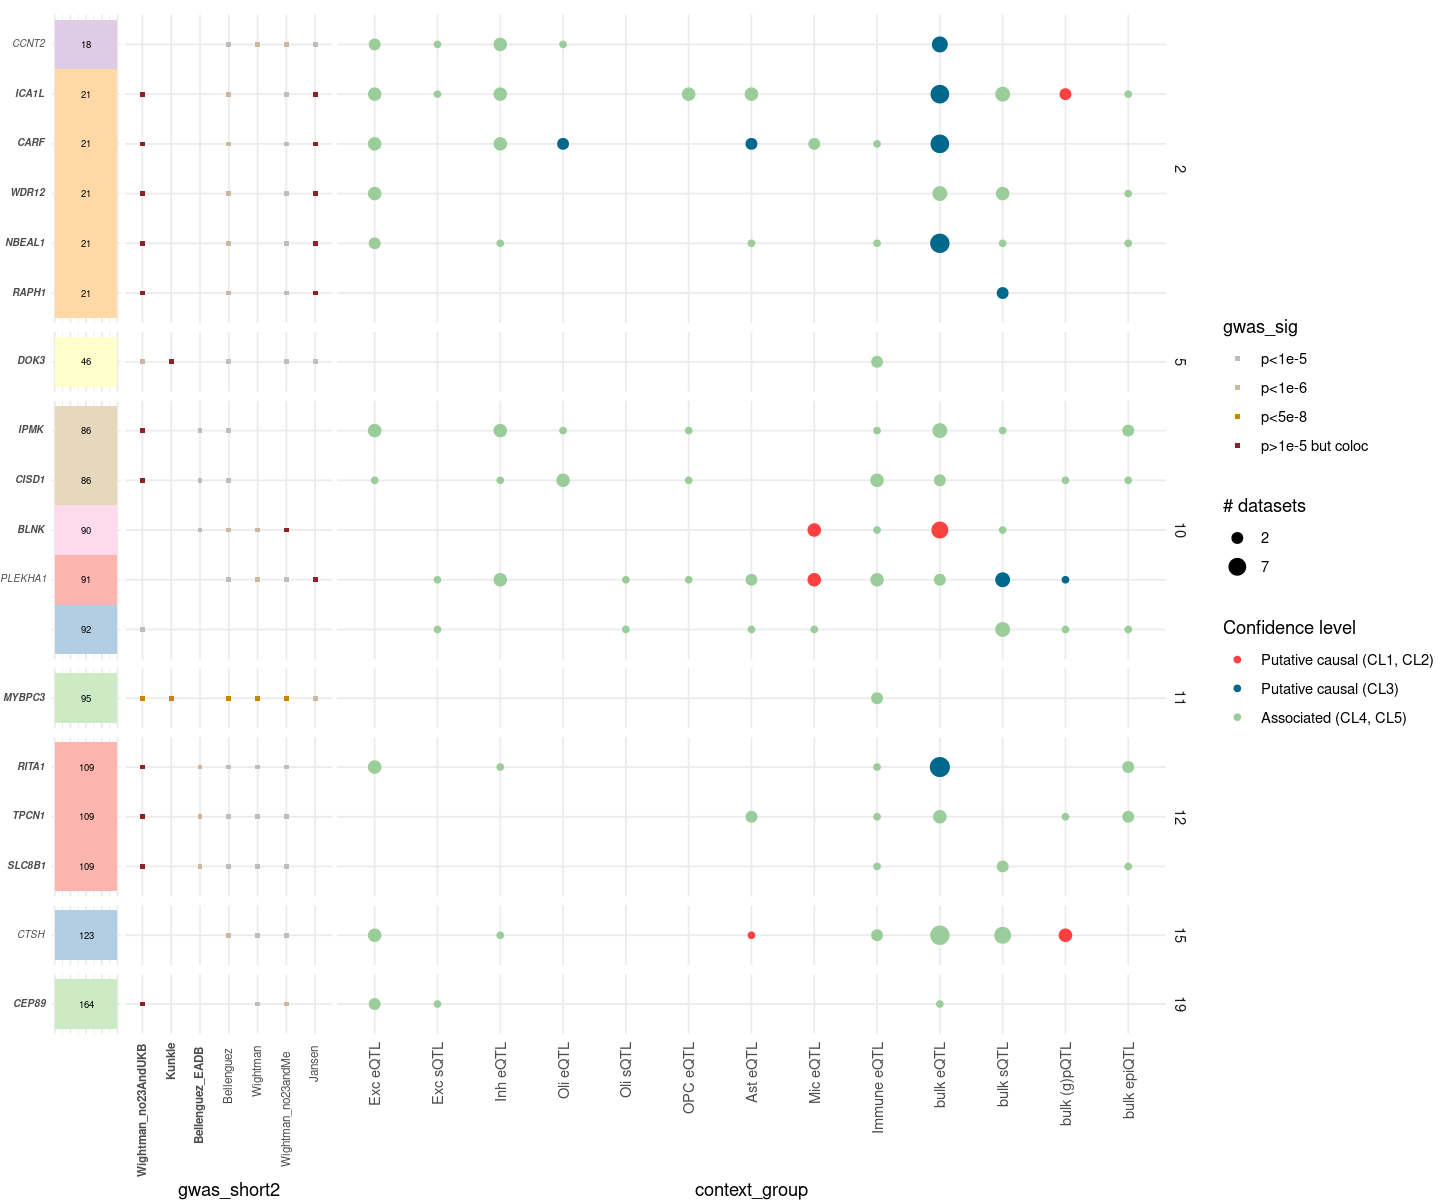

In [8]:
options(repr.plot.width = 12, repr.plot.height = 10)

res_adxlocf<-res_adxloc[!(genomewide_sig_gene)][gene_name%in%gene_name[confidence_lvl_group%in%c('CL1','CL2','CL3','CL4')&n_gwas_locus>2&n_study_group.locus>=2]]

res_adxlocf_cont<-unique(res_adxlocf,by=c('gene_name','context_group','locus_index'))


#sep causal vs correlated 
#add if frpm, APOE region, from AD by proxy only, or from more than one locus

res_adxlocf_cont[,confidence_cat_group:=ifelse(confidence_lvl_group.locus%in%c('CL1',"CL2"),'Putative causal (CL1, CL2)',ifelse(confidence_lvl_group.locus=='CL3','Putative causal (CL3)','Associated (CL4, CL5)'))]
res_adxlocf_cont[,confidence_cat_group:=factor(confidence_cat_group,levels = c('Putative causal (CL1, CL2)','Putative causal (CL3)','Associated (CL4, CL5)'))]

#annot genes
res_adxlocf_cont[,locus_gene_2:=paste(gene_name,match(locus_gene,
                                                           unique(locus_gene[order(chr,tss,min_pval)])),sep='_'),
                      by=.(gene_name)]

res_adxlocf_cont[,locus_gene_2:=paste0("<i>",locus_gene_2[1],'</i>'),
                      by='locus_gene']

#add if from  AD by proxy only
res_adxlocf_cont[,locus_gene_2:=ifelse(!all(only_by_proxi,na.rm = T),paste0("<b>",locus_gene_2[1],'</b>'),
                                            locus_gene_2[1]),
                      by='locus_gene']

#order per gene tss and locus position
res_adxlocf_cont[,locus_gene_3:=factor(locus_gene_2,levels = unique(locus_gene_2[order(chr,-tss,-min_pval)]))]


ps<-SummPanel(res_adxlocf_cont,res_adxloc_gwas)

wrap_plots(ps)+plot_layout(guides = 'collect',widths = c(0.5,1.5,6))&
  theme(plot.margin = margin(0, 0, 0, 0)) 



These genes are foundfor at least 2 datasets from same context group overlapping/coloc with at least 3 GWAS .  
BLNK and CTSH already discussed in Xuewei paper, so focus on the others top gene for each locus (with highest CL).

### ICA1L
pQTL is MR significant as already found in a [previous study](https://pubmed.ncbi.nlm.nih.gov/34381170/), confirming that increase protein abundance associate with less risk of AD. Interestingly here we found that these variants (top: chr2:202800206:C:G) associate with **decrease** RNA production, in variety of cell type and in bulk, and also associate with reduction of unproductive splicing. One mechanism therefore could be that the variant (which is in intron 9) is helping reduce unproductive mRNA splicing, therefore more productive splicing can be translated into protein.
Also described involved in stroke, small vessel disease and mechanism could be through myelin disruption .


### RITA1
- Tubulin-binding protein that acts as a negative regulator of Notch signaling pathway, and help reduce DNA damage through p53 activation[[ref](https://aacrjournals.org/mct/article/21/10/1524/709525/Decreased-DNA-Damage-and-Improved-p53-Specificity)].  
- the AD locus, present in Bellenguez, Jansen and Wightman overlap  with **Exc specific eQTL** and have been identified as a new AD locus in this study. 2 independant mQTL signal falling in this AD locus, suggesting epigenetic regulation of this gene
- is MR significant in bulk brain eQTL
- chr12:113239646:C:T downstream of the gene, decrease its expression which increase AD risk

### DOK3

- DOK3 have 5/7 GWAS overlapping with Immune eQTL
- is in the center node of the PPI.
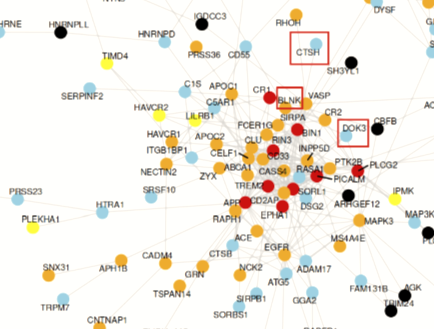
- Overlap with both bulk Macrophage and Microglia eQTL
- known to interact with INPP5D to negatively regulate JNK singaling
==> good AD candidate, even if not TWAS significant

### PLEKHA1
- is cTWAS significant in Mic
- reduced Mic and protein expression lead to reduce AD risk 
- known  Age Related Macular Degeneration gene, and already found [MR significant in AD](https://link.springer.com/article/10.1007/s10787-024-01583-z)
- bind a lipid signaling molecule, important for regulating immune response 

### CCNT2
- regulate transcription elongation by RNA polymerase II controling of early and late viral transcription, important regulator of HIV and other retrovirus development
- chr2:134904108:A:G increase CCNT2 expression, particularly in Inh, which increase AD risk

### CEP89 
 cs95 from 3 GWAS (wightman and its 2 subsets) overlap with Exc eQTL and sQTL. top1 variant based on cV2F score is in intron of CEP89. involved ciliogenesis, cell projection and synaptic transmission. Do not seems to have been nominated before as an AD gene.
 
 #

## Relaxing to include CL5 gene
i.e. allows also overlap based on coloc or cs70%

Warning message:
“Item 2 has 8 rows but longest item has 23; recycled with remainder.”


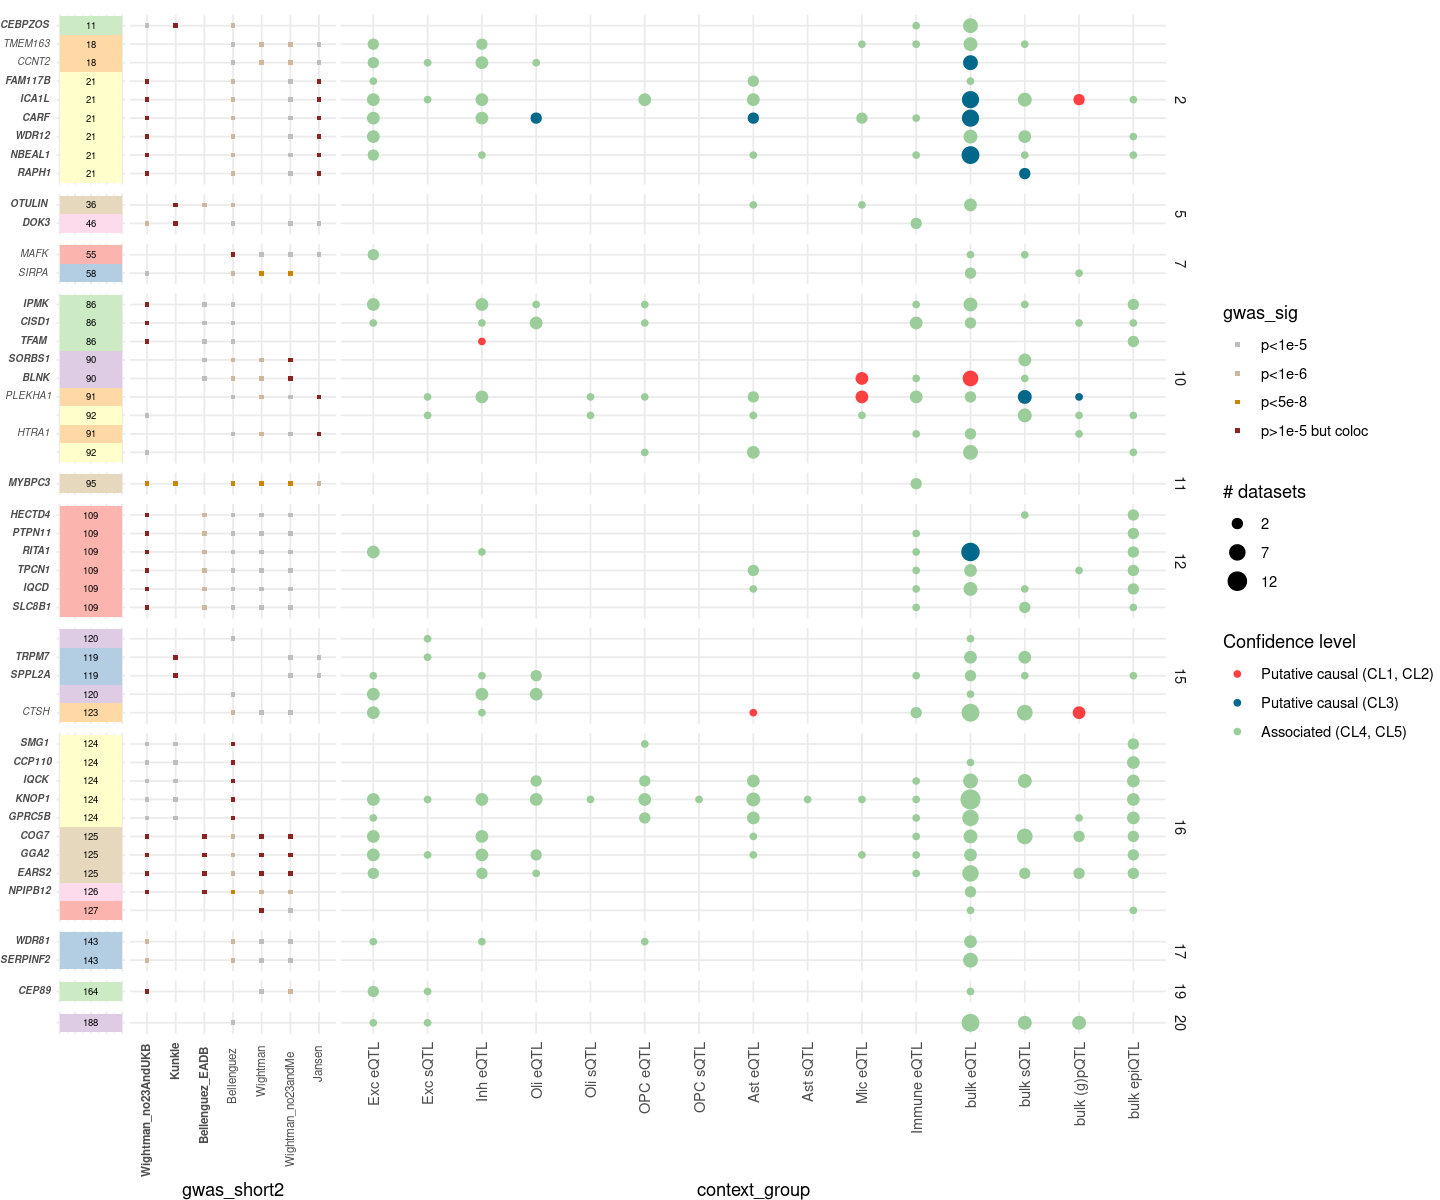

In [11]:
options(repr.plot.width = 12, repr.plot.height = 10)

#relax to CL5
res_adxlocf<-res_adxloc[!(genomewide_sig_gene)][gene_name%in%gene_name[confidence_lvl_group%in%c('CL1','CL2','CL3','CL4','CL5')&n_gwas_locus>2&n_study_group.locus>=2]]

res_adxlocf_cont<-unique(res_adxlocf,by=c('gene_name','context_group','locus_index'))


#sep causal vs correlated 
#add if frpm, APOE region, from AD by proxy only, or from more than one locus

res_adxlocf_cont[,confidence_cat_group:=ifelse(confidence_lvl_group.locus%in%c('CL1',"CL2"),'Putative causal (CL1, CL2)',ifelse(confidence_lvl_group.locus=='CL3','Putative causal (CL3)','Associated (CL4, CL5)'))]
res_adxlocf_cont[,confidence_cat_group:=factor(confidence_cat_group,levels = c('Putative causal (CL1, CL2)','Putative causal (CL3)','Associated (CL4, CL5)'))]

#annot genes
res_adxlocf_cont[,locus_gene_2:=paste(gene_name,match(locus_gene,
                                                           unique(locus_gene[order(chr,tss,min_pval)])),sep='_'),
                      by=.(gene_name)]

res_adxlocf_cont[,locus_gene_2:=paste0("<i>",locus_gene_2[1],'</i>'),
                      by='locus_gene']

#add if from  AD by proxy only
res_adxlocf_cont[,locus_gene_2:=ifelse(!all(only_by_proxi,na.rm = T),paste0("<b>",locus_gene_2[1],'</b>'),
                                            locus_gene_2[1]),
                      by='locus_gene']

#order per gene tss and locus position
res_adxlocf_cont[,locus_gene_3:=factor(locus_gene_2,levels = unique(locus_gene_2[order(chr,-tss,-min_pval)]))]


ps<-SummPanel(res_adxlocf_cont,res_adxloc_gwas)

wrap_plots(ps)+plot_layout(guides = 'collect',widths = c(0.5,1.5,6))&
  theme(plot.margin = margin(0, 0, 0, 0)) 




### KNOP1
3 GWAS overlap with 8+ bulk eQTL, as well as mQTL,  Exc, Inh, Oli OPCs e and sQTL
Have been identified as TWAS/MR significant in a [previous study](https://link.springer.com/article/10.1007/s10787-024-01583-z) 

### SPPL2A
4 GWAS (J, K, W, and B) from cs95 overlap with the 3 Oli eQTL (as well as Exc and  Inh but in only 2 datasets). the signal is splitted in 2 'independant' loci (num 122 and 123): locus 122 is where J, K, and W coloc is found while locus 123 is where B signal is found, but bothe have some coloc with Oli eQTL so these 2 loci are probably in LD.

SPPL2A is GxGD aspartyl proteases in lysosome and known to [cleave the AD gene TMEM106B](https://www.sciencedirect.com/science/article/pii/S0021925820477300 )




 
 